In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import skorch

In [3]:
import numpy as np

In [5]:
from deepspeech.model import DeepSpeech
from deepspeech.data.data_loader import SpectrogramParser

/home/nemo/envs/noswear/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [6]:
from noswear.data import dataset
from noswear.utils import filter_low_count_words

We are building upon DeepSpeech CNN layers.

In [7]:
base_model = DeepSpeech.load_model(
    '../models/librispeech_pretrained.pth'
)
audio_conf = DeepSpeech.get_audio_conf(base_model)
parser = SpectrogramParser(audio_conf, normalize=True)
sampler = dataset.SOXSampler(sample_rate=audio_conf['sample_rate'])

We have our own swear/non-swear data, load it.

In [8]:
ds_swear = dataset.SwearDataset(base_path='../', providers=dataset.DEFAULT_PROVIDERS)

In [9]:
X_swear, y_swear = ds_swear.load()

In [10]:
ds = dataset.SwearBinaryAudioDataset(X_swear, y_swear, parser, sampler)

In [11]:
X, y = ds.load()

### Pad data

In [12]:
seq_lens = np.array([x.shape[1] for x in X])
max_seq_len = max(seq_lens)
max_seq_len, np.mean(seq_lens), np.median(seq_lens)

(301, 102.18613138686132, 78.0)

In [13]:
X_pad = np.zeros(
    (len(X), X[0].shape[0], max_seq_len), 
    dtype='float32'
)
for i, _ in enumerate(X):
    X_pad[i, :, :seq_lens[i]] = X[i]
    
y = np.array(y)

### Plotting helper

In [14]:
# since we have batched processing, we remove the batch dimension
# outputs.shape = (len(X_valid), 4, ?) => (len(X_valid), 4*?)
def debatch_indicator_sequences(outputs):
    def a():
        for _, _, indicator_seqs in outputs:
            for seq in indicator_seqs:
                yield seq
    return list(a())

In [15]:
def plot_seq_base(indicator_sequence, clogit, fpath):
    swear = clogit >= 0.5
    title = f"{fpath} - swear: {swear}"
    
    plt.title(title)
    plt.plot(indicator_sequence)
    plt.legend(['indic. neuron'])
    
def plot_seq(i):
    sequence = indicator_sequences[i]
    clogit = class_log[i]
    fpath = np.array(X_swear)[valid_idcs][i][1]
    
    plot_seq_base(sequence, clogit, fpath)

### Make data sliceable, load model

In [16]:
from skorch.helper import SliceDict

In [17]:
X_train = {'lens': seq_lens, 'X': X_pad}
y_train = np.array(y).astype('float32')
X_slable = SliceDict(**X_train)

In [18]:
from noswear.model import load_model

In [19]:
net = load_model(base_model, {'f_pickle': 'model_val_acc_best.pkl'})

### let's test streaming manually

the idea is that we chunk the data and feed it step by step to the model. we expect the chunk-feeding to have approx. the same result as if we feed the data in one big chunk.

In [125]:
def step(memory, net, subject, N, i=None):
    if i is None:
        assert memory
        i = len(memory)

    if i == 0:
        assert not memory
        X_new_i = {
            'lens': [N],
            'X': subject['X'][:, :, 0:N],
        }
    else:
        X_new_i = {
            'lens': [N + N//2],
            'X': subject['X'][:, :, N*i - N//2:N*(i+1)],
            'h0': memory[-1]['hXs'],
            'c0': memory[-1]['cXs'],
        }
    print(f'step {i}: {N*(i+1)} of', subject['lens'][0])
    
    (ys, inds, indss, hXs, cXs) = list(net.forward_iter(X_new_i))[0]
    memory.append({'X': X_new_i, 'hXs': hXs, 'cXs': cXs})
    
    return ys, torch.sigmoid(ys[0])>=0.5, inds

We test this manually by stepping through one specific sample:

In [155]:
idx = slice(0, 1)
subject = X_slable[idx]
N = 40
memory = []

In [156]:
subject['lens'], y_train[idx], net.predict(subject)

(array([184]), array([0.], dtype=float32), array([0], dtype=uint8))

In [157]:
step(memory, net, subject, N, i=0)

step 0: 40 of 184


(tensor([-0.0773]), tensor(False), tensor([0.2351]))

In [158]:
step(memory, net, subject, N)

step 1: 80 of 184


(tensor([-0.3900]), tensor(False), tensor([0.9062]))

In [159]:
step(memory, net, subject, N)

step 2: 120 of 184


(tensor([-0.0624]), tensor(False), tensor([0.1351]))

In [160]:
step(memory, net, subject, N)

step 3: 160 of 184


(tensor([-0.0775]), tensor(False), tensor([0.0610]))

In [161]:
step(memory, net, subject, N)

step 4: 200 of 184


(tensor([-0.0785]), tensor(False), tensor([0.0635]))

This looks good, we can automate the stepping now.

In [177]:
def run_steps(net, subject, N):
    memory = []
    
    max_len = subject['lens'][0]
    num_steps = (max_len // N)+1
    results = {'y': [], 'p': [], 'ind': []}
    
    for i in range(num_steps):
        ys, p, ind = step(memory, net, subject, N, i)
        results['y'].append(ys[0])
        results['p'].append(p)
        results['ind'].append(ind[0])
    
    d_idx = np.argmax(results['ind'])
    print('indicators:', results['ind'])
    return results['p'][d_idx], d_idx

Let's do some runs with automated stepping and see if it is working anecdotally.

---

In [205]:
idx = slice(0, 1)
subject = X_slable[idx]
print('expected: ', y_train[idx])
print('non-streaming result: ', net.predict(subject))

expected:  [0.]
non-streaming result:  [0]


In [206]:
y, idx = run_steps(net, subject, N)
print(f'streaming result (idx={idx}): {y:d}')

step 0: 40 of 184
step 1: 80 of 184
step 2: 120 of 184
step 3: 160 of 184
step 4: 200 of 184
indicators: [tensor(0.2351), tensor(0.9062), tensor(0.1351), tensor(0.0610), tensor(0.0635)]
streaming result (idx=1): 0


---

In [225]:
idx = slice(1, 2)
subject = X_slable[idx]
print('expected: ', y_train[idx])
print('non-streaming result: ', net.predict(subject))

expected:  [0.]
non-streaming result:  [1]


In [226]:
y, idx = run_steps(net, subject, N)
print(f'streaming result (idx={idx}): {y:d}')

step 0: 40 of 177
step 1: 80 of 177
step 2: 120 of 177
step 3: 160 of 177
step 4: 200 of 177
indicators: [tensor(0.0604), tensor(0.8278), tensor(0.8695), tensor(0.1022), tensor(0.0630)]
streaming result (idx=2): 1


---

In [227]:
idx = slice(3, 4)
subject = X_slable[idx]
print('expected: ', y_train[idx])
print('non-streaming result: ', net.predict(subject))

expected:  [0.]
non-streaming result:  [0]


In [228]:
y, idx = run_steps(net, subject, N)
print(f'streaming result (idx={idx}): {y:d}')

step 0: 40 of 112
step 1: 80 of 112
step 2: 120 of 112
indicators: [tensor(0.1142), tensor(0.5524), tensor(0.2936)]
streaming result (idx=1): 0


---

Now that we know that some samples looked good, we can compare streaming results for the whole data set.

In [215]:
y_static = net.predict(X_slable)

In [216]:
y_stream = []
for i in range(len(X_slable)):
    idx = slice(i, i+1)
    subject = X_slable[idx]
    y, _idx = run_steps(net, subject, N)
    y_stream.append(y)

step 0: 40 of 184
step 1: 80 of 184
step 2: 120 of 184
step 3: 160 of 184
step 4: 200 of 184
indicators: [tensor(0.2351), tensor(0.9062), tensor(0.1351), tensor(0.0610), tensor(0.0635)]
step 0: 40 of 177
step 1: 80 of 177
step 2: 120 of 177
step 3: 160 of 177
step 4: 200 of 177
indicators: [tensor(0.0604), tensor(0.8278), tensor(0.8695), tensor(0.1022), tensor(0.0630)]
step 0: 40 of 76
step 1: 80 of 76
indicators: [tensor(0.7202), tensor(0.4332)]
step 0: 40 of 112
step 1: 80 of 112
step 2: 120 of 112
indicators: [tensor(0.1142), tensor(0.5524), tensor(0.2936)]
step 0: 40 of 51
step 1: 80 of 51
indicators: [tensor(0.0125), tensor(0.0819)]
step 0: 40 of 65
step 1: 80 of 65
indicators: [tensor(-0.2107), tensor(0.0583)]
step 0: 40 of 62
step 1: 80 of 62
indicators: [tensor(0.0571), tensor(0.0587)]
step 0: 40 of 58
step 1: 80 of 58
indicators: [tensor(-0.1626), tensor(0.0430)]
step 0: 40 of 51
step 1: 80 of 51
indicators: [tensor(0.1388), tensor(0.0723)]
step 0: 40 of 227
step 1: 80 of 227


indicators: [tensor(-0.2084), tensor(0.0828)]
step 0: 40 of 213
step 1: 80 of 213
step 2: 120 of 213
step 3: 160 of 213
step 4: 200 of 213
step 5: 240 of 213
indicators: [tensor(0.3454), tensor(0.1240), tensor(0.1764), tensor(0.1790), tensor(0.1605), tensor(0.1754)]
step 0: 40 of 101
step 1: 80 of 101
step 2: 120 of 101
indicators: [tensor(0.4336), tensor(0.6623), tensor(0.0871)]
step 0: 40 of 62
step 1: 80 of 62
indicators: [tensor(0.1149), tensor(0.1105)]
step 0: 40 of 73
step 1: 80 of 73
indicators: [tensor(-0.1979), tensor(0.2562)]
step 0: 40 of 62
step 1: 80 of 62
indicators: [tensor(0.1280), tensor(0.5709)]
step 0: 40 of 55
step 1: 80 of 55
indicators: [tensor(0.0055), tensor(0.0906)]
step 0: 40 of 58
step 1: 80 of 58
indicators: [tensor(-0.0715), tensor(0.0613)]
step 0: 40 of 55
step 1: 80 of 55
indicators: [tensor(-0.0256), tensor(0.0593)]
step 0: 40 of 33
indicators: [tensor(-0.2855)]
step 0: 40 of 141
step 1: 80 of 141
step 2: 120 of 141
step 3: 160 of 141
indicators: [tensor

step 1: 80 of 58
indicators: [tensor(-0.3279), tensor(0.0608)]
step 0: 40 of 73
step 1: 80 of 73
indicators: [tensor(0.0402), tensor(0.3109)]
step 0: 40 of 54
step 1: 80 of 54
indicators: [tensor(0.1069), tensor(0.0610)]
step 0: 40 of 201
step 1: 80 of 201
step 2: 120 of 201
step 3: 160 of 201
step 4: 200 of 201
step 5: 240 of 201
indicators: [tensor(0.1749), tensor(0.1632), tensor(0.1697), tensor(0.1797), tensor(0.1748), tensor(0.0775)]
step 0: 40 of 301
step 1: 80 of 301
step 2: 120 of 301
step 3: 160 of 301
step 4: 200 of 301
step 5: 240 of 301
step 6: 280 of 301
step 7: 320 of 301
indicators: [tensor(0.4047), tensor(0.3554), tensor(0.2176), tensor(0.5274), tensor(0.1629), tensor(0.1976), tensor(0.5354), tensor(0.2189)]
step 0: 40 of 201
step 1: 80 of 201
step 2: 120 of 201
step 3: 160 of 201
step 4: 200 of 201
step 5: 240 of 201
indicators: [tensor(0.4950), tensor(0.3681), tensor(0.4193), tensor(0.3139), tensor(0.1153), tensor(0.0623)]
step 0: 40 of 201
step 1: 80 of 201
step 2: 12

indicators: [tensor(0.0480), tensor(0.8168), tensor(0.3807)]
step 0: 40 of 33
indicators: [tensor(0.5338)]
step 0: 40 of 119
step 1: 80 of 119
step 2: 120 of 119
indicators: [tensor(0.0965), tensor(0.8874), tensor(0.1395)]
step 0: 40 of 80
step 1: 80 of 80
step 2: 120 of 80
indicators: [tensor(0.9311), tensor(0.1023), tensor(0.0935)]
step 0: 40 of 73
step 1: 80 of 73
indicators: [tensor(0.9363), tensor(0.1802)]
step 0: 40 of 195
step 1: 80 of 195
step 2: 120 of 195
step 3: 160 of 195
step 4: 200 of 195
indicators: [tensor(0.3846), tensor(0.2475), tensor(0.0728), tensor(0.0676), tensor(0.0675)]
step 0: 40 of 80
step 1: 80 of 80
step 2: 120 of 80
indicators: [tensor(0.5380), tensor(0.0099), tensor(0.0622)]
step 0: 40 of 220
step 1: 80 of 220
step 2: 120 of 220
step 3: 160 of 220
step 4: 200 of 220
step 5: 240 of 220
indicators: [tensor(0.6924), tensor(0.6974), tensor(0.1873), tensor(0.1995), tensor(0.1653), tensor(0.1508)]
step 0: 40 of 58
step 1: 80 of 58
indicators: [tensor(-0.2617), t

In [221]:
y_stream = [int(n) for n in y_stream]

In [223]:
(y_static == y_stream).mean()

0.8795620437956204

So comparing with the static feeding we have ~88% accuracy when streaming. Maybe can reduce this error further.

In [37]:
spec = X_slable[0:1]['X'][0]

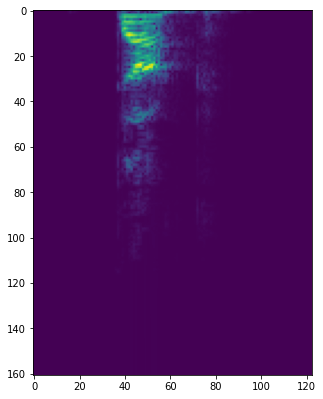

In [38]:
plt.figure(figsize=(5,9))
plt.imshow(spec[:, :123])

In [39]:
audio_spect = parser.parse_audio('../data/own/shiiiit.ogg')
inp = {'X': audio_spect[None], 'lens': np.array([audio_spect.shape[1]])}

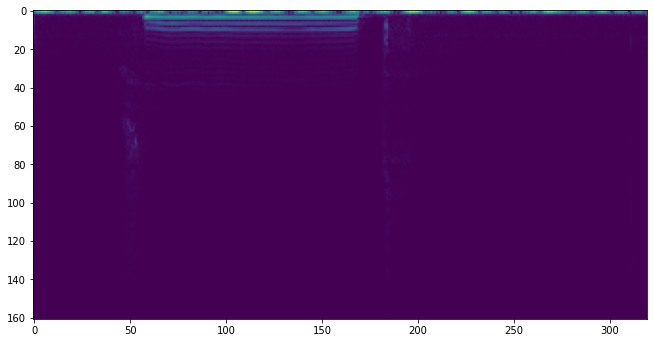

In [40]:
plt.figure(figsize=(11, 9))
plt.imshow(audio_spect[:, :audio_spect.shape[1]])

In [41]:
from deepspeech.data.data_loader import load_audio
import librosa

In [42]:
def parse_audio_stream(self, y):
    n_fft = int(self.sample_rate * self.window_size)
    win_length = n_fft
    hop_length = int(self.sample_rate * self.window_stride)
    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=self.window)
    spect, phase = librosa.magphase(D)
    # S = log(S+1)
    spect = np.log1p(spect)
    spect = torch.FloatTensor(spect)
    if self.normalize:
        mean = spect.mean()
        std = spect.std()
        spect.add_(-mean)
        spect.div_(std)
    return spect

In [154]:
# use librosa.load instead of load_audio because we can set the SR
audio_stream, sr = librosa.load('../data/own/shiiiit.ogg', sr=16000)

In [156]:
def lowpass(x, a):
    y = x.copy()
    y[0] = a * x[0]
    for i in range(1, len(x)):
        y[i] = (1-a) * y[i-1] + a * x[i]
    return y

In [157]:
def highpass(x, a):
    y = x.copy()
    for i in range(1, len(x) - 1):
        y[i] = a * (y[i-1] + x[i] - x[i-1])
    return y

In [158]:
def highpass_freq(x, fc, sampling_rate):
    a = 1 / (2*np.pi*(1/sampling_rate)*fc + 1)
    return highpass(x, a)

In [159]:
from scipy import signal

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=1):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [160]:
audio_inp_filtered = highpass_freq(audio_stream, 1000, sampling_rate=16e3)
audio_inp_filtered = butter_highpass_filter(audio_stream, 300, 16e3)
audio_spect_filtered = parse_audio_stream(parser, audio_inp_filtered)

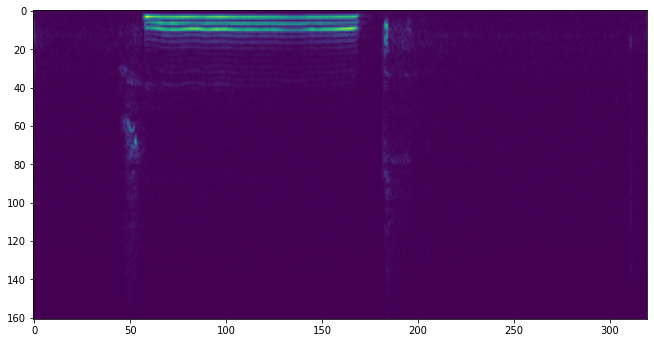

In [161]:
plt.figure(figsize=(11, 9))
plt.imshow(audio_spect_filtered[:, :audio_spect_filtered.shape[1]])

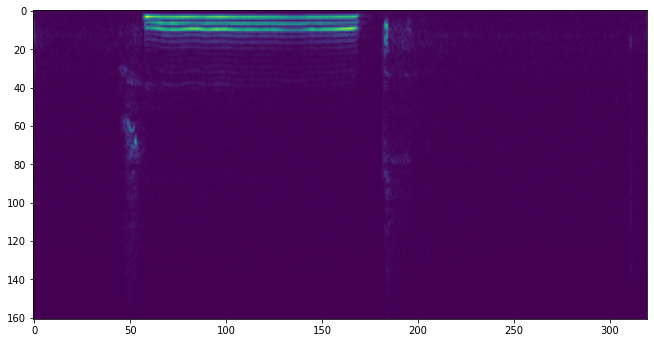

In [162]:
plt.figure(figsize=(11, 9))
plt.imshow(audio_spect_filtered[:, :audio_spect_filtered.shape[1]])

In [178]:
inp = {'X': audio_spect[None], 'lens': np.array([audio_spect.shape[1]])}
net.predict(inp)

array([0], dtype=uint8)

In [179]:
inp_filtered = {'X': audio_spect_filtered[None], 'lens': np.array([audio_spect_filtered.shape[1]])}
net.predict(inp_filtered)

array([1], dtype=uint8)

In [180]:
net.predict_proba(inp_filtered)

array([[0.47617006, 0.52382994]], dtype=float32)

In [183]:
c, i, ics, hX, cX = zip(*list(net.forward_iter(inp)))

In [193]:
torch.sigmoid(c[0])

tensor([0.0269])

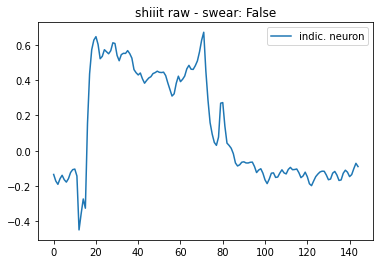

In [184]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit raw')

In [173]:
c, i, ics, hX, cX = zip(*list(net.forward_iter(inp_filtered)))

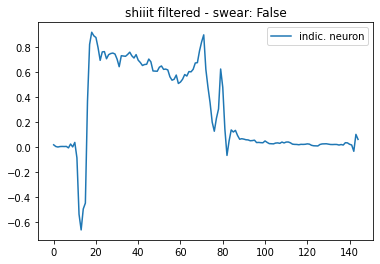

In [174]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit filtered')

In [145]:
audio_stream = load_audio('../data/own/shiiiit.ogg')

In [59]:
net.predict(X_slable[4:5])

array([0], dtype=uint8)

Let's inspect the indicator neuron (what does it do)

In [60]:
outputs = list(net.forward_iter(X_train))

It seems to strongly, inversely correlate with the predicted output class

In [61]:
class_log, indicator_log, indicator_sequence_log = zip(*outputs)
class_log = torch.cat(class_log)
indicator_log = torch.cat(indicator_log)

ValueError: too many values to unpack (expected 3)

In [ ]:
plt.plot(class_log)
plt.ylabel('class logit')

ax = plt.twinx()
ax.plot(indicator_log, c='orange')
plt.ylabel('indicator logit')

plt.gcf().legend(['class', 'indic']);

How does it evolve in time?

In [ ]:
indicator_sequences = debatch_indicator_sequences(outputs)

In [ ]:
plot_seq(0)

In [ ]:
plot_seq(2)

In [ ]:
plot_seq(3)

In [ ]:
plot_seq(4)

In [ ]:
plot_seq(20)

In [ ]:
plot_seq(27)

Test on a single sample, a long-stretched 'shiiit'

In [ ]:
audio_inp = parser.parse_audio('../data/own/shiiiit.ogg')
inp = {'X': audio_inp[None], 'lens': np.array([audio_inp.shape[1]])}

In [ ]:
c, i, ics = zip(*list(net.forward_iter(inp)))

In [ ]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit')